In [90]:
import csv
import pandas as pd
import numpy as np
import math
from datetime import datetime as dt, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None 

from funcs import driver_status
from funcs import get_col_name
from funcs import maxer
from funcs import maxer_2
from funcs import check_truck
# from funcs import money

In [2]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is B0D1-7E59

 Directory of C:\Users\hp\Desktop\due_dilligence_2

11/27/2022  06:50 PM    <DIR>          .
11/27/2022  06:50 PM    <DIR>          ..
11/27/2022  01:08 PM    <DIR>          .ipynb_checkpoints
11/27/2022  03:14 PM         7,763,232 data21.xlsx
11/27/2022  03:20 PM        14,439,045 data22.xlsx
11/27/2022  03:21 PM         1,524,300 datasep.xlsx
11/27/2022  04:54 PM           402,162 driver_status.xlsx
11/27/2022  06:50 PM            31,456 due_dilligence2_(driver_analysis).ipynb
11/27/2022  05:50 PM             2,382 funcs.py
11/27/2022  06:27 PM               688 geo.csv
11/27/2022  06:47 PM               711 geo_2.csv
11/27/2022  01:06 PM               734 Read Me.txt
11/28/2022  11:48 AM    <DIR>          __pycache__
               9 File(s)     24,164,710 bytes
               4 Dir(s)  19,685,195,776 bytes free


I had to break down the data from the question raw data in illa overview to 3 questions using illa overview's filters for 2021,2022 and sep2022 to download the 3 excels and use then merge them here to have all the transactional data in one df 

In [3]:
df1 = pd.read_excel("data21.xlsx")
df2 = pd.read_excel("data22.xlsx")
df3 = pd.read_excel("datasep.xlsx")

In [39]:
df_dstatus = pd.read_excel("driver_status.xlsx")
df_dstatus = df_dstatus.rename(columns = {"Driver Name":"driver_name"})

In [130]:
df = pd.concat([df1,df2], axis = 0)
df = pd.concat([df,df3], axis = 0)
df["trip_date"]= pd.to_datetime(df["trip_date"])
df["month_year"] = df["trip_date"].dt.strftime('%m/%Y').astype('datetime64')
df= df[df["trips_status"].isin(["Completed", "Not_loaded","Not_requested"])]
df["trucks"] = df["truck_type"].apply(check_truck)

In [7]:
print(df["trip_date"].min())
print(df["trip_date"].max())

2021-06-01 00:00:00
2022-09-30 00:00:00


In [91]:
def money(val):
       if "dababa" in val:
        return 150
       elif "jumbo" in val:
        return 200
       elif ("trailer" in val)|("side" in val):
        return 350
       elif "van" in val:
        return 150 

In [131]:
df_combo = df.merge(df_dstatus[["driver_name","All trips","Driver Class",]], on ="driver_name")
df_combo = df_combo.rename(columns ={"All trips":"all_trips","Driver Class":"driver_class"})
df_combo['monetary']= df_combo["trucks"].apply(money)

In [9]:
# ### Needed functions
# def get_col_name(row):    
#     b = (df2.index[row.name] == row['value'])
#     return b.index[b.argmax()]

# def maxer(df,s=0,e=12):
#     max_index = []
#     for i in df.index.values:
#         max_index.append(df.iloc[:,s:e].loc[str(i)].idxmax())
#     return pd.Series(max_index, name = "max_month", index=df.index)

# def maxer_2(df,s=0,e=12):
#     max_index = []
#     for i in df.index.values:
#         max_index.append(df.iloc[:,s:e].iloc[i].idxmax())
#     return pd.Series(max_index, name = "max_month", index=df.index)

# def check_truck(val):
#           val =  val.lower().replace('_'," ").replace("-"," ").split()
#           if "jumbo" in val:
#             return "jumbo"
#           elif "dababa" in val:
#             return "dababa"
#           elif ("trella" in val)|("side" in val):
#             return "trailer"
#           elif "van" in val:
#             return "van"

##### Slide2 __(active vs new drivers) (5 in pres)

In [10]:
########### We aggregate data according to month year  
driver_month_pivot =  df.pivot_table(index=["driver_name"], 
                                    columns=["month_year"], 
                                    values=["id"], 
                                    aggfunc="count", 
                                    fill_value=0)
driver_month_pivot = driver_month_pivot.applymap(lambda x: 1 if x>0 else 0)
########## Func driver status is imported from the module funcs in the same direcotry with two arguments
########## df and number of months(cols), it just shows the status of each driver everymonth 


driver_month_pivot= driver_month_pivot.reset_index()
cols  = [str(i[1])[:-9] for i in list(driver_month_pivot.columns)]
cols.insert(1,"driver")
cols= cols[1:]
driver_month_pivot.columns = cols
driver_month_pivot= driver_month_pivot.set_index("driver")
driver_month_status = pd.DataFrame(driver_month_pivot.apply(lambda x: pd.Series(driver_status(x,len(driver_month_pivot.columns))), axis=1))

driver_month_status.columns = driver_month_pivot.columns

driver_month_status
month_status_pivot = pd.DataFrame(driver_month_status.replace("unreg", np.NaN).apply(lambda x: pd.value_counts(x)))
month_status_pivot = month_status_pivot.fillna(0)
month_status_pivot 

,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01
active,0.0,123,170,181,213,221,215,261,283,285,370,334,338,347,342,293
inactive,0.0,134,285,438,561,686,909,1118,1290,1443,1707,2010,2230,2505,2736,2940
new,257.0,198,164,155,133,217,255,194,155,349,267,224,284,226,155,197


##### Slide3 __(driver count vs trips count) (6 in pres)

In [11]:
slide_1 = df.groupby(['month_year','driver_name']).count().groupby(['month_year']).count().reset_index().iloc[:,[0,1]].rename(columns={"id":"driver_count"}).merge(
df.groupby(['month_year','driver_name']).count().groupby(["month_year"]).sum().reset_index().iloc[:,[0,1]].rename(columns={"id":"trips_count"}), on = "month_year",how ="left").transpose()

# slide_1.columns = ["jun21", "jul21","aug21","sep21","oct21","nov21","dec21","jan22","feb22","mar22","apr22"]
###################### cols from slide 1 
slide_1.columns = cols[1:]
slide_1 = slide_1.drop(slide_1.index[[0]],axis= 0)
slide_1

,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01
driver_count,257,321,334,336,346,438,470,455,438,634,637,558,622,573,497,490
trips_count,2070,3188,4178,5218,4999,4575,4749,5083,5249,6482,7302,8071,6839,6829,7460,5722


##### Slide4__(first to last growth (7 in pres)

In [12]:
slide_1 = df.copy()

slide_1 = slide_1.groupby(['month_year']).agg({'driver_name':'nunique','id':'count', "manual_distance":"sum","client_name":"nunique","supplier_name":"nunique","branch_name":"nunique","pickup_gov":"nunique","truck_type":"nunique"})
slide_1.columns  =['driver_ucounts', 'trips_count',"distance_covered","clients_ucount","supp_ucount","branch_ucount", "gov_ucount","truck_types"]
slide_1 = slide_1.transpose()#.reset_index().iloc[:,[0,1]].rename(columns={"id":"driver_count"}).merge(slide_1.groupby(['month_year','driver_name']).count().groupby(["month_year"]).sum().reset_index().iloc[:,[0,1]].rename(columns={"id":"trips_count"}), on = "month_year",how ="left").transpose()
# slide_1.columns = cols[1:]
slide_1.columns = ["jun21","jul21","aug21","sep21","oct21","nov21","dec21","jan22","feb22","mar22","apr22","may22","jun22","jul22",
                  "aug22","sep22"]

slide_1= slide_1.drop(columns=["jun22"])
slide_1= slide_1.join(pd.Series(slide_1.max(axis=1), name = "max_val", dtype= "float64"))
slide_1 = slide_1.join(maxer(slide_1))
slide_1["growth_1st_last"]= round(((slide_1["sep22"] - slide_1["jun21"])/slide_1["jun21"])+1,1)
slide_1["growth_1st_top"]= round(((slide_1["max_val"] - slide_1["jun21"])/slide_1["jun21"])+1,1)
# slide_1["growth_1st_last%"]= round(((slide_1["may22"] - slide_1["jul21"])/slide_1["jul21"])*100,0)
# slide_1["growth_1st_top%"]= round(((slide_1["max_val"] - slide_1["jul21"])/slide_1["jul21"])*100,0)

slide_1.iloc[:,[0,14,17]]

,jun21,sep22,growth_1st_last
driver_ucounts,257.0,490.0,1.9
trips_count,2079.0,5722.0,2.8
distance_covered,209800.0,538130.2,2.6
clients_ucount,20.0,34.0,1.7
supp_ucount,53.0,67.0,1.3
branch_ucount,59.0,158.0,2.7
gov_ucount,16.0,24.0,1.5
truck_types,17.0,20.0,1.2


##### Slide5__(driver count vs trips count)(by gov) (8 in pres)

In [17]:
geo_1 = df.groupby(["pickup_gov","driver_name","month_year"]).agg({"id":"count"}).unstack(level=2).fillna(0).reset_index() 

geo_1.columns= ["pickup_gov","driver_name","jun21","jul21","aug21","sep21","oct21","nov21","dec21","jan22","feb22","mar22","apr22","may22","jun22","jul22",
                  "aug22","sep22"]

geo_1= geo_1.groupby(["pickup_gov"]).agg({"driver_name":"nunique",
                                   "jun21":"sum",	"jul21":"sum"	,"aug21":"sum",	"sep21":"sum",	"oct21":"sum",
                                   "nov21":"sum",	"dec21":"sum",	"jan22":"sum"	,"feb22":"sum",	"mar22":"sum",
                                   "apr22":"sum",	"may22":"sum","jun22":"sum",
                                         "jul22":"sum", "aug22":"sum","sep22":"sum"}).reset_index()

geo_1["all_trips"] = geo_1.sum(axis=1)
geo_1["growth_1st_last"]= round(((geo_1["may22"] - geo_1["jun21"])/(geo_1["jun21"]+0.01))+1,1)
geo_1.sort_values(by=["all_trips"], ascending = False).reset_index(drop= True)[["pickup_gov","driver_name","all_trips"]].to_csv("geo.csv")



##### Slide6__(driver count vs trips count)(by gov map) (9 in pres)

In [18]:
geo_2 = geo_1.sort_values(by=["pickup_gov"], ascending = True).reset_index(drop= True)[["pickup_gov","driver_name","all_trips"]]
geo_2 = geo_2.append(geo_2.loc[10]).reset_index(drop= True).drop(index=10)
geo_2.loc[24.5]= pd.Series({"pickup_gov":"Shamal Sinai","driver_name":0,"all_trips":0}, name=25)
geo_2.sort_index().reset_index(drop= True).to_csv("geo_2.csv")

##### Slide7__(Cohort Drivers)(by gov map) (10 in pres)

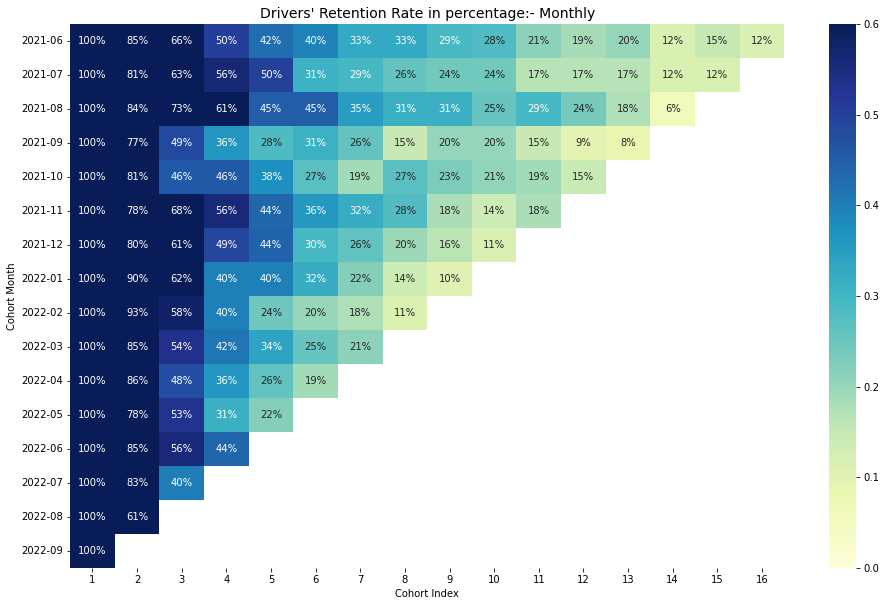

In [50]:
#### we filter on monthly clients and drivers with more than 10 trips(trials) 
df_cohort= df_combo[(df_combo["all_trips"]>10)].reset_index(drop=True)
grouping = df_cohort.groupby('driver_name')['month_year'] 
df_cohort['CohortMonth'] = grouping.transform('min')

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

transcation_year, transaction_month, _ = get_date_int(df_cohort, 'month_year')
cohort_year, cohort_month, _ = get_date_int(df_cohort, 'CohortMonth')
years_diff = transcation_year - cohort_year
months_diff = transaction_month - cohort_month
df_cohort['CohortIndex'] = years_diff * 12 + months_diff  + 1 
grouping = df_cohort.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['driver_name'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns ='CohortIndex',
                                 values = 'driver_name')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.index = retention.index.strftime('%Y-%m')
retention.index
plt.figure(figsize=(16, 10))
plt.title("Drivers' Retention Rate in percentage:- Monthly", fontsize = 14)
sns.heatmap(retention, annot=True, fmt= '.0%',cmap='YlGnBu', vmin = 0.0 , vmax = 0.6)
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

##### Slide8__(Cohort Drivers)(by gov map) (11 in pres)

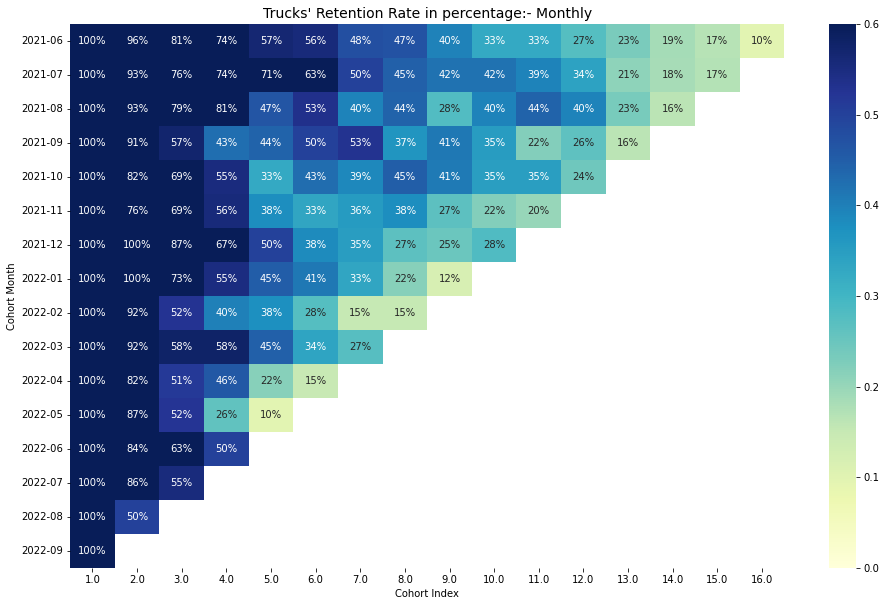

In [54]:
#### we filter on monthly clients and drivers with more than 10 trips(trials) 
df_cohort= df_combo[(df_combo["all_trips"]>10)].reset_index(drop=True)
grouping = df_cohort.groupby('plate_number')['month_year'] 
df_cohort['CohortMonth'] = grouping.transform('min')

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

transcation_year, transaction_month, _ = get_date_int(df_cohort, 'month_year')
cohort_year, cohort_month, _ = get_date_int(df_cohort, 'CohortMonth')
years_diff = transcation_year - cohort_year
months_diff = transaction_month - cohort_month
df_cohort['CohortIndex'] = years_diff * 12 + months_diff  + 1 
grouping = df_cohort.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['driver_name'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns ='CohortIndex',
                                 values = 'driver_name')
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.index = retention.index.strftime('%Y-%m')
retention.index
plt.figure(figsize=(16, 10))
plt.title("Trucks' Retention Rate in percentage:- Monthly", fontsize = 14)
sns.heatmap(retention, annot=True, fmt= '.0%',cmap='YlGnBu', vmin = 0.0 , vmax = 0.6)
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

#### Retail 

In [71]:
def retailer(val):
    val =  val.lower().replace('_'," ").replace("-"," ").replace('/'," ").split()
    if "تجزئة" in val:
        return "retail"
    else:
        return "non_retail"   

In [78]:
df2_retail = df.copy()
df2_retail= df2_retail.dropna(subset = ["dropoff_type"])

df2_retail.isnull().sum()
df2_retail = df2_retail.join(pd.get_dummies(df2_retail["trucks"]))

df2_retail["retail"]= df2_retail["dropoff_type"].apply(retailer)


df2_retail_2 = pd.DataFrame(df2_retail.pivot_table(index="retail", 
                                              values=["id","supplier_name","driver_name", "manual_distance", "trip_duration", "dababa", "jumbo","trailer","van", "plate_number"], 
                                              aggfunc={"id": "count","driver_name":pd.Series.nunique,"supplier_name":pd.Series.nunique,"manual_distance":sum, "trip_duration":sum,
                                                       "dababa":sum, "jumbo":sum,"trailer":sum,"van":sum,
                                                       "plate_number":pd.Series.nunique}))
df2_retail_2 = df2_retail_2.reset_index()
df2_retail_2.columns = ["retail", "dababa_trips", "driver_count", "trip_count","jumbo_trips","distance", "truck_count","supplier_count", "trella_trips","duration","van_trips"]
df2_retail_2 = df2_retail_2.iloc[:,[0,2,6,3,1,4,8,10,5,9]]
df_sec= pd.DataFrame(df2_retail.groupby(["retail","trucks"])["plate_number"].nunique()).unstack().reset_index()
df_sec.columns= [ "retail","dababa_count","jumbo_count","trella_count","van"]

df2_retail_2 =df2_retail_2.merge(df_sec)
df2_retail_2 = df2_retail_2.iloc[:,[0,1,2,3,10,4,11,5,12,6,13,7,8,9]]

##### Slide9__(retail duration and Kms ) (12 in pres)

In [80]:
pd.DataFrame(df2_retail.groupby(["retail","trucks"])["trip_duration"].mean()).unstack().fillna(0)#.to_csv("retail_duration.csv")

trip_duration                               
truck             dababa      jumbo   trailer       van
retail                                                 
non_retail     11.057698  10.261367  11.88715  0.959854
retail          9.835033  11.870638  39.00000  6.057279

In [79]:
pd.DataFrame(df2_retail.groupby(["retail","trucks"])["manual_distance"].mean()).unstack().fillna(0)

manual_distance                                    
truck               dababa       jumbo     trailer         van
retail                                                        
non_retail      134.949620  100.732046  118.012107   63.656934
retail           90.046861  162.683808  700.000000  126.402148

##### Slide10__( unique drivers by contract type) (13 in pres)

In [67]:
df_t_2= df[["month_year","contract_type","driver_name"]].groupby(["month_year","contract_type"])["driver_name"].nunique().unstack().fillna(0).reset_index().drop(columns = ["Daily Rental"])#.to_csv("contract_type.csv")
df_t_2 = df_t_2.T
df_t_2.columns = cols[1:]
df_t_2 = df_t_2.iloc[1:,:]
df_t_2

,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01
contract_type,,,,,,,,,,,,,,,,
Monthly,101.0,150.0,165.0,208.0,206.0,187.0,186.0,241.0,242.0,311.0,258.0,309.0,361.0,389.0,333.0,292.0
On_demand,172.0,184.0,188.0,142.0,161.0,260.0,309.0,244.0,226.0,381.0,438.0,282.0,271.0,200.0,170.0,195.0


##### Slide10__( trip counts by contract type) (14in pres)

In [68]:
df_t_2= df[["month_year","contract_type","driver_name"]].groupby(["month_year","contract_type"])["driver_name"].count().unstack().fillna(0).reset_index().drop(columns = ["Daily Rental"])#.to_csv("contract_type.csv")
df_t_2 = df_t_2.T
df_t_2.columns = cols[1:]
df_t_2 = df_t_2.iloc[1:,:]
df_t_2

,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01
contract_type,,,,,,,,,,,,,,,,
Monthly,1240.0,1967.0,2423.0,3171.0,3097.0,2555.0,2679.0,3120.0,2967.0,4486.0,4228.0,4860.0,5012.0,5842.0,6274.0,4452.0
On_demand,818.0,1221.0,1755.0,2047.0,1902.0,2020.0,2070.0,1963.0,2272.0,1972.0,3044.0,3183.0,1784.0,934.0,1123.0,1232.0


# Driver RFM Model

In [227]:
driver_data = pd.DataFrame(df_combo.pivot_table(index="driver_name", 
                                              values=["trip_date","id", "manual_distance","month_year","monetary"], 
                                              aggfunc={"trip_date": [min, max, pd.Series.nunique],"id": "count","manual_distance":sum,"month_year":pd.Series.nunique,"monetary":"sum"}))

driver_data = driver_data.sort_values(by= [('id','count')], ascending = False).reset_index()
driver_data.columns = [ "driver_name","trip_count","distance","monetary","unique_months", "last_trip", "first_trip","unique_days"]
driver_data= driver_data.merge(df_combo.groupby(['driver_name'])['overnight_count'].sum().reset_index()[["driver_name","overnight_count"]],on = "driver_name")
driver_data["trip_count"]+=driver_data["overnight_count"]
driver_data= driver_data.drop(columns = "overnight_count" )
driver_data["first_trip"]= driver_data["first_trip"].astype("datetime64")
driver_data["last_trip"]=driver_data["last_trip"].astype("datetime64")
today_2022 = driver_data["last_trip"].max()
driver_data["lifetime"] = (today_2022 - driver_data["first_trip"]).dt.days
driver_data["recency"] = np.ceil((today_2022 - driver_data["last_trip"]).dt.days)
### Frequency here is the merge of the distance * trip_count
driver_data["frequency"]=driver_data["trip_count"]*driver_data["distance"]
driver_data["log_frequency"]= np.log(driver_data["frequency"])
driver_data["log_monetary"]= np.log(driver_data["monetary"])
# driver_data["rel_frequency"] = np.round(driver_data["frequency"] / driver_data["unique_days"],2)
# driver_data["rel_recency"] = np.round(1 - (driver_data["recency"] / driver_data["lifetime"]),2)
driver_data= driver_data.iloc[:,[0,1,2,3,4,5,6,7,8,10,9,11,12]]
driver_data = driver_data.dropna()
driver_data

,driver_name,trip_count,distance,monetary,unique_months,last_trip,first_trip,unique_days,lifetime,frequency,recency,log_frequency,log_monetary
0,خالد خطاب محمد محمد,506.0,26992.0,99800,14,2022-09-30,2021-07-07,329,450,13657952.0,0.0,16.429832,11.510923
1,عبد الحافظ السيد عبدالحافظ السيد,473.0,51269.0,70950,16,2022-09-29,2021-06-01,415,486,24250237.0,1.0,17.003937,11.169731
2,ربيع شعبان عبدالمعطي ابوالعزم,432.0,33201.0,86200,13,2022-06-30,2021-06-28,267,459,14342832.0,92.0,16.478761,11.364425
3,قنديل مجدي قنديل عبدالعزيز,409.0,22585.0,61350,16,2022-09-29,2021-06-01,409,486,9237265.0,1.0,16.038756,11.024350
4,رضا صبحي رجب السيد,406.0,22108.0,60900,16,2022-09-29,2021-06-01,406,486,8975848.0,1.0,16.010048,11.016988
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,سيد طه عواد محمد,1.0,54.0,150,1,2021-07-15,2021-07-15,1,442,54.0,442.0,3.988984,5.010635
3281,محمد سعد الله عبدالقادر فرج,1.0,35.0,350,1,2022-07-28,2022-07-28,1,64,35.0,64.0,3.555348,5.857933
3282,احمد جمال محمد يوسف,2.0,600.0,350,1,2022-04-14,2022-04-14,1,169,1200.0,169.0,7.090077,5.857933
3283,محمد سالم سعد حسن البطش,1.0,57.0,150,1,2021-11-06,2021-11-06,1,328,57.0,328.0,4.043051,5.010635


In [228]:
### Needed functions
def maxer(df):
    max_index = []
    for i in df_combo.select_dtypes(include=["float"]).columns:
        max_index.append(df_combo[str(i)].idxmax())
    return pd.Series(max_index, name = "max_index")
def create_p(df,col,start,*args):
      p = []
      if start !=None:
        bins=[start]
      else:
        bins=[]
      cols= []
      c=0
      for i in list(args):
        p.append((c,"{}%".format(i) ,np.percentile(df[col], i)))
        bins.append(np.percentile(df[col], i))
        cols.append(np.percentile(df[col], i))
        c+=1
      p.append((c,"max", df[col].max()))
      bins.append(df[col].max())  
      cols.append(df[col].max())  
      print(p)
      return bins,cols

In [229]:
df_trucks_2= pd.DataFrame(pd.DataFrame(df_combo.groupby(["driver_name"]).count().reset_index()[df_combo.groupby(["driver_name"]).agg({"trucks":"nunique"}).reset_index()["trucks"]>1]["driver_name"]).reset_index(drop= True).merge(df_combo[["driver_name","trucks"]], on ="driver_name", how = "inner").groupby(["driver_name","trucks"])["trucks"].count()).unstack(level= 0).fillna(0).reset_index()
tcols = []
for i in df_trucks_2.columns:
    tcols.append(i[1])
df_trucks_2.columns = tcols
help=[""]  
for i in maxer(df_trucks_2):
    df_trucks_2 = df_trucks_2.transpose().reset_index()
    df_trucks_2 = df_trucks_2.join(pd.Series(help, name = "truck_type")).drop(index=[0]).reset_index(drop=True)[["index","truck_type"]]
    df_trucks_2.columns = ["driver_name","truck_type"]
    df_trucks_1= df_combo.groupby(["driver_name","trucks"]).count().reset_index()[["driver_name","trucks"]].drop_duplicates(subset=["driver_name"], keep='first').reset_index(drop= True)
    df_trucks= df_trucks_1.merge(df_trucks_2, on = "driver_name",how = "left").fillna(0)
for i in df_trucks["truck_type"].index.values:
    if df_trucks.loc[i]["truck_type"]!=0:
        df_trucks.loc[i]["trucks"]=df_trucks.loc[i]["truck_type"]
df_trucks[df_trucks["truck_type"]!=0]
driver_data = driver_data.merge(df_trucks[["driver_name","trucks"]],how = "left")
driver_data

,driver_name,trip_count,distance,monetary,unique_months,last_trip,first_trip,unique_days,lifetime,frequency,recency,log_frequency,log_monetary,trucks
0,خالد خطاب محمد محمد,506.0,26992.0,99800,14,2022-09-30,2021-07-07,329,450,13657952.0,0.0,16.429832,11.510923,jumbo
1,عبد الحافظ السيد عبدالحافظ السيد,473.0,51269.0,70950,16,2022-09-29,2021-06-01,415,486,24250237.0,1.0,17.003937,11.169731,dababa
2,ربيع شعبان عبدالمعطي ابوالعزم,432.0,33201.0,86200,13,2022-06-30,2021-06-28,267,459,14342832.0,92.0,16.478761,11.364425,jumbo
3,قنديل مجدي قنديل عبدالعزيز,409.0,22585.0,61350,16,2022-09-29,2021-06-01,409,486,9237265.0,1.0,16.038756,11.024350,dababa
4,رضا صبحي رجب السيد,406.0,22108.0,60900,16,2022-09-29,2021-06-01,406,486,8975848.0,1.0,16.010048,11.016988,dababa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,سيد طه عواد محمد,1.0,54.0,150,1,2021-07-15,2021-07-15,1,442,54.0,442.0,3.988984,5.010635,dababa
3281,محمد سعد الله عبدالقادر فرج,1.0,35.0,350,1,2022-07-28,2022-07-28,1,64,35.0,64.0,3.555348,5.857933,trailer
3282,احمد جمال محمد يوسف,2.0,600.0,350,1,2022-04-14,2022-04-14,1,169,1200.0,169.0,7.090077,5.857933,trailer
3283,محمد سالم سعد حسن البطش,1.0,57.0,150,1,2021-11-06,2021-11-06,1,328,57.0,328.0,4.043051,5.010635,dababa


In [245]:
rfm = pd.DataFrame()
rfm['driver_name'] = driver_data.driver_name

count    3285.000000
mean      190.649924
std       137.777497
min         0.000000
25%        75.000000
50%       172.000000
75%       290.000000
max       486.000000
Name: recency, dtype: float64
[(0, '25%', 75.0), (1, '50%', 172.0), (2, '75%', 290.0), (3, 'max', 486.0)]
[-1, 75.0, 172.0, 290.0, 486.0]


,4,3,2,1
percentiles,75.0,172.0,290.0,486.0
count,817.0,823.0,819.0,826.0


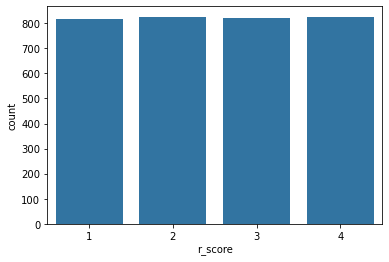

In [253]:
print(driver_data.recency.describe())
r_bins, r_cols = create_p(driver_data, "recency",-1,25,50,75)
print(r_bins)
rfm["r_score"] = pd.cut(driver_data["recency"], 
                                       bins=r_bins, 
                                       labels=[4,3,2,1],duplicates='drop').astype(int)
color = sns.color_palette()[0]
sns.countplot(rfm['r_score'], color = color)
dfr = rfm["r_score"].value_counts().sort_index().reset_index().transpose().drop(index = "index", axis =0).astype("int")
dfr = dfr.append(pd.Series(r_cols), ignore_index = True)
dfr = dfr.reindex([1,0]).reset_index(drop =True).rename(index = {0:'percentiles', 1:' count'})
#
dfr.columns = [4,3,2,1]
#
dfr

count    3285.000000
mean            -inf
std              NaN
min             -inf
25%         5.192957
50%         7.124478
75%        10.301055
max        17.003937
Name: log_frequency, dtype: float64
[(0, '25%', 5.19295685089021), (1, '50%', 7.124478262493424), (2, '75%', 10.301054888517152), (3, 'max', 17.003936948495884)]
[-1, 5.19295685089021, 7.124478262493424, 10.301054888517152, 17.003936948495884]


,1,2,3,4
percentiles,5.192957,7.124478,10.301055,17.003937
count,748.000000,821.000000,821.000000,821.000000


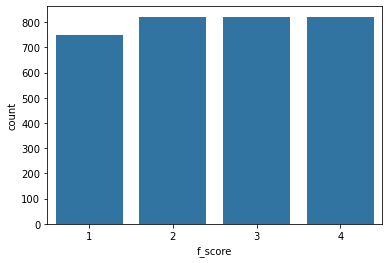

In [254]:
print(driver_data.log_frequency.describe())
f_bins, f_cols = create_p(driver_data, "log_frequency",-1,25,50,75)
print(f_bins)
#????
rfm["f_score"] = pd.cut(driver_data["log_frequency"], 
                                       bins=f_bins, 
                                       labels=[1,2,3,4])#.astype(int)
rfm["f_score"].value_counts()
sns.countplot(rfm['f_score'], color = color)
dfs = rfm["f_score"].value_counts().sort_index().reset_index().transpose().drop(index = "index", axis =0).astype("int")
dfs = dfs.append(pd.Series(f_cols), ignore_index = True)
dfs = dfs.reindex([1,0]).reset_index(drop =True).rename(index = {0:'percentiles', 1:' count'})
#
dfs.columns = [1,2,3,4]
dfs

count    3285.000000
mean        6.964666
std         1.615986
min         5.010635
25%         5.703782
50%         6.551080
75%         8.160518
max        11.524360
Name: log_monetary, dtype: float64
[(0, '25%', 5.703782474656201), (1, '50%', 6.551080335043404), (2, '75%', 8.160518247477505), (3, 'max', 11.524359842595892)]


,1,2,3,4
percentiles,5.703782,6.55108,8.160518,11.52436
count,844.000000,867.00000,754.000000,820.00000


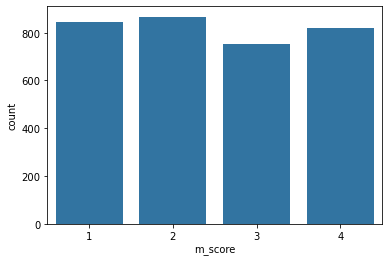

In [255]:
print(driver_data.log_monetary.describe())
c_bins, c_cols = create_p(driver_data, "log_monetary",-1,25,50,75)
c_bins
#????
rfm["m_score"] = pd.cut(driver_data["log_monetary"], 
                                       bins=c_bins, 
                                       labels=[1, 2, 3, 4])#.astype("int")
rfm["m_score"].value_counts()
rfm["m_score"].value_counts()
sns.countplot(rfm['m_score'], color = color)
dfc = rfm["m_score"].value_counts().sort_index().reset_index().transpose().drop(index = "index", axis =0).astype("int")
dfc = dfc.append(pd.Series(c_cols), ignore_index = True)
dfc = dfc.reindex([1,0]).reset_index(drop =True).rename(index = {0:'percentiles', 1:' count'})
dfc.columns = [1,2,3,4]
dfc

In [259]:
rfm

,driver_name,r_score,f_score,m_score
0,خالد خطاب محمد محمد,4,4,4
1,عبد الحافظ السيد عبدالحافظ السيد,4,4,4
2,ربيع شعبان عبدالمعطي ابوالعزم,3,4,4
3,قنديل مجدي قنديل عبدالعزيز,4,4,4
4,رضا صبحي رجب السيد,4,4,4
...,...,...,...,...
3280,سيد طه عواد محمد,1,1,1
3281,محمد سعد الله عبدالقادر فرج,4,1,2
3282,احمد جمال محمد يوسف,3,2,2
3283,محمد سالم سعد حسن البطش,1,1,1


In [260]:
rfm["r_score"]= rfm["r_score"].astype("int")
rfm["f_score"]= rfm["r_score"].astype("int")
rfm["m_score"]= rfm["r_score"].astype("int")

In [261]:
rfm["RFM"] = rfm["r_score"] + rfm["f_score"]+rfm["m_score"] 
print(rfm["RFM"].value_counts().sort_index().reset_index().transpose())
rfm

         0    1    2    3
index    3    6    9   12
RFM    817  823  819  826


,driver_name,r_score,f_score,m_score,RFM
0,خالد خطاب محمد محمد,4,4,4,12
1,عبد الحافظ السيد عبدالحافظ السيد,4,4,4,12
2,ربيع شعبان عبدالمعطي ابوالعزم,3,3,3,9
3,قنديل مجدي قنديل عبدالعزيز,4,4,4,12
4,رضا صبحي رجب السيد,4,4,4,12
...,...,...,...,...,...
3280,سيد طه عواد محمد,1,1,1,3
3281,محمد سعد الله عبدالقادر فرج,4,4,4,12
3282,احمد جمال محمد يوسف,3,3,3,9
3283,محمد سالم سعد حسن البطش,1,1,1,3
